# 1. Install Required Libraries

In [4]:
!pip install google-api-python-client
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install matplotlib
!pip install textblob

# 2. Import Libraries

In [1]:
import googleapiclient.discovery
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# 3. Define API Key and API Service

In [2]:
API_KEY = "Your API Key"  # Store this securely, e.g., in an environment variable
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'


Conclusion: Set up API key and service details for accessing YouTube API.

# 4. Define Function to Search Videos

In [3]:
def search_videos(query, max_results=5):
    youtube = googleapiclient.discovery.build(
        YOUTUBE_API_SERVICE_NAME,
        YOUTUBE_API_VERSION,
        developerKey=API_KEY
    )

    request = youtube.search().list(
        part='snippet',
        q=query,
        maxResults=max_results,
        type='video'
    )
    response = request.execute()

    video_ids = []
    for item in response['items']:
        video_ids.append(item['id']['videoId'])

    return video_ids


Conclusion: This function searches for YouTube videos based on a query and returns their IDs.

# 5. Search for Videos

In [4]:
query = 'Python tutorial'
video_ids = search_videos(query)
print(video_ids)

['_uQrJ0TkZlc', 'UrsmFxEIp5k', 'kqtD5dpn9C8', 'rfscVS0vtbw', 'ERCMXc8x7mc']


Conclusion: Execute the video search function and print video IDs based on the query.

# 6. Define Function to Get Comments

In [5]:
def get_comments(video_id):
    youtube = googleapiclient.discovery.build(
        YOUTUBE_API_SERVICE_NAME,
        YOUTUBE_API_VERSION,
        developerKey=API_KEY
    )

    comments = []
    timestamps = []
    commenters = []
    next_page_token = None

    while True:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            pageToken=next_page_token,
            maxResults=100,
            textFormat='plainText'
        )
        response = request.execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            timestamp = item['snippet']['topLevelComment']['snippet']['publishedAt']
            commenter = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comments.append(comment)
            timestamps.append(timestamp)
            commenters.append(commenter)

        next_page_token = response.get('nextPageToken')
        if next_page_token is None:
            break

    return comments, timestamps, commenters


Conclusion: This function retrieves comments, timestamps, and commenters from a YouTube video.

# 7. Collect Comments from Video

In [6]:
if video_ids:
    comments, timestamps, commenters = get_comments(video_ids[0])
    df = pd.DataFrame({
        'comment': comments,
        'timestamp': timestamps,
        'commenter': commenters
    })
    df.to_csv('youtube_comments.csv', index=False)


Conclusion: If video IDs are available, fetch comments from the first video and save them to a CSV file.

# 8. Clean Comment Text

In [7]:
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment'].apply(clean_text)


 Conclusion: Clean the comment text by removing URLs, special characters, and converting to lowercase.

# 9. Get Sentiment of Comments

In [9]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['cleaned_comment'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')


Conclusion: Calculate sentiment polarity of comments and classify them as positive, negative, or neutral.

# 10. Extract Time Features

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_name()


Conclusion: Convert timestamp to datetime and extract hour and day of the week features.



# 11. Save Data to CSV

In [11]:
df.to_csv('youtube_comments_with_timestamps.csv', index=False)


Conclusion: Save the processed data including comments, timestamps, sentiment, and time features to a CSV file.

# 12. Sentiment Over Time

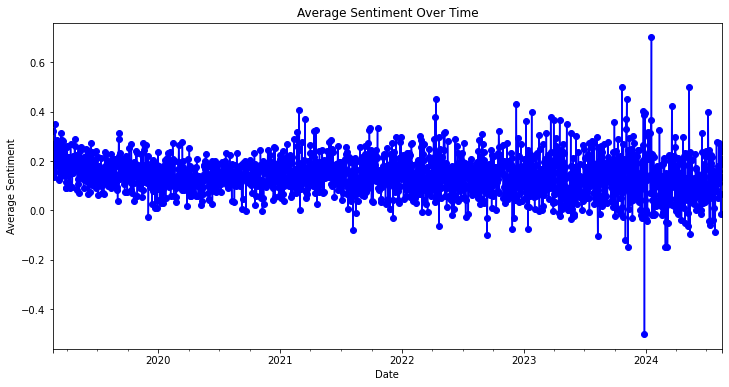

In [12]:
plt.figure(figsize=(12, 6))
df.resample('D')['sentiment'].mean().plot(kind='line', marker='o', color='blue')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()


Conclusion: Plot the average sentiment over time to observe trends.

# 13. Top Commenters

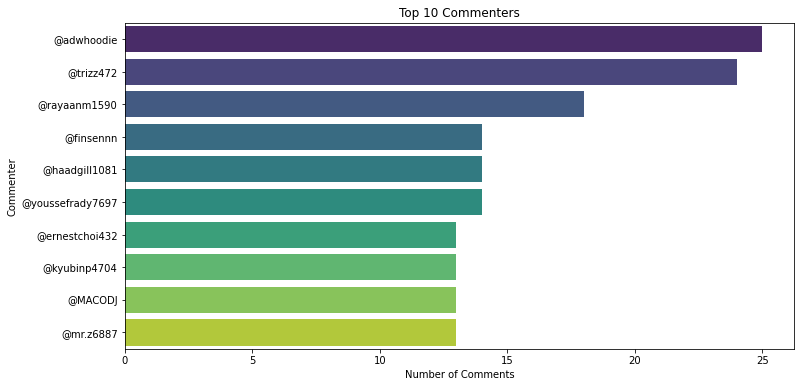

In [13]:
plt.figure(figsize=(12, 6))
top_commenters = df['commenter'].value_counts().head(10)
sns.barplot(x=top_commenters.values, y=top_commenters.index, palette='viridis')
plt.title('Top 10 Commenters')
plt.xlabel('Number of Comments')
plt.ylabel('Commenter')
plt.show()


Conclusion: Visualize the top 10 commenters based on the number of comments.

# 14. Sentiment vs. Comment Length

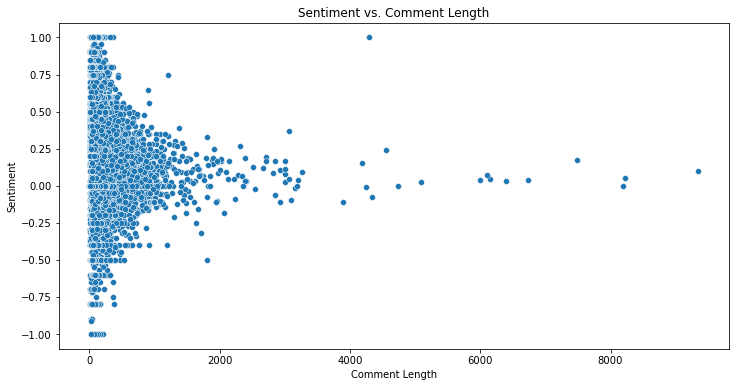

In [14]:
df['comment_length'] = df['cleaned_comment'].apply(len)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='comment_length', y='sentiment', data=df)
plt.title('Sentiment vs. Comment Length')
plt.xlabel('Comment Length')
plt.ylabel('Sentiment')
plt.show()


Conclusion: Scatter plot showing the relationship between comment length and sentiment.

# 15. Average Sentiment by Hour of Day

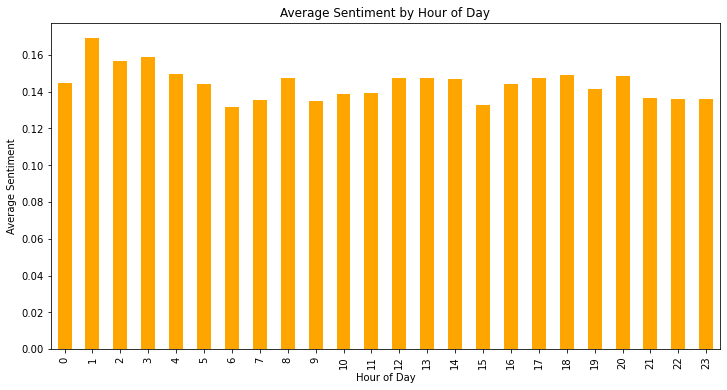

In [15]:
plt.figure(figsize=(12, 6))
df.groupby('hour')['sentiment'].mean().plot(kind='bar', color='orange')
plt.title('Average Sentiment by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Sentiment')
plt.show()


Conclusion: Bar plot showing average sentiment by hour of the day.

# 16. Sentiment Distribution

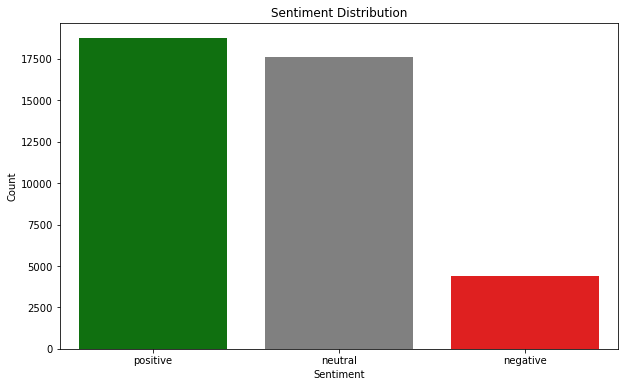

In [16]:
palette = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df, palette=palette)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


Conclusion: Display the distribution of sentiments (positive, negative, neutral) across comments.

# 17. Word Cloud for All Comments

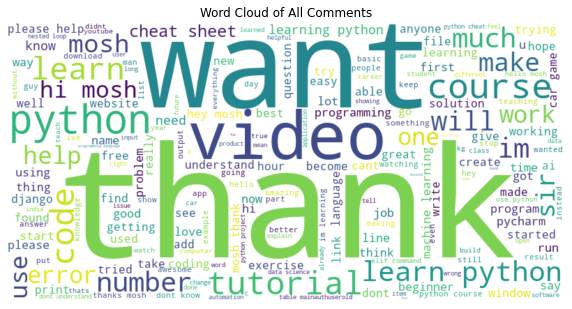

In [18]:
text = ' '.join(df['cleaned_comment'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Comments')
plt.show()


Conclusion: Generate a word cloud to visualize the most frequent words in all comments.

# 18. Correlation Heatmap

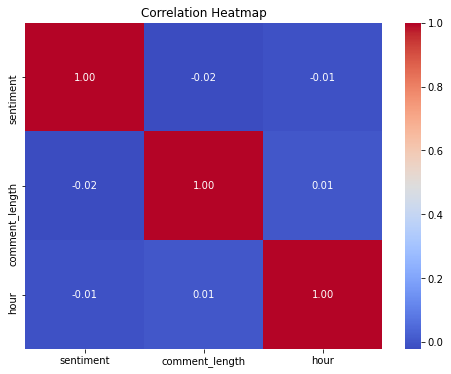

In [19]:
df_numeric = df[['sentiment', 'comment_length', 'hour']]
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Conclusion: Display a heatmap of correlations between sentiment, comment length, and hour of the day.

# 19. Sentiment Distribution by Day of the Week

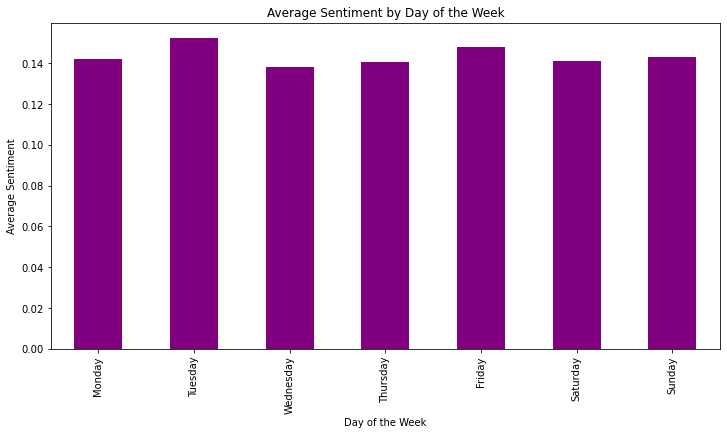

In [20]:
plt.figure(figsize=(12, 6))
df.groupby('day_of_week')['sentiment'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', color='purple')
plt.title('Average Sentiment by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sentiment')
plt.show()


Conclusion: Bar plot showing average sentiment by day of the week.


# 20. Comment Length Distribution by Day of the Week

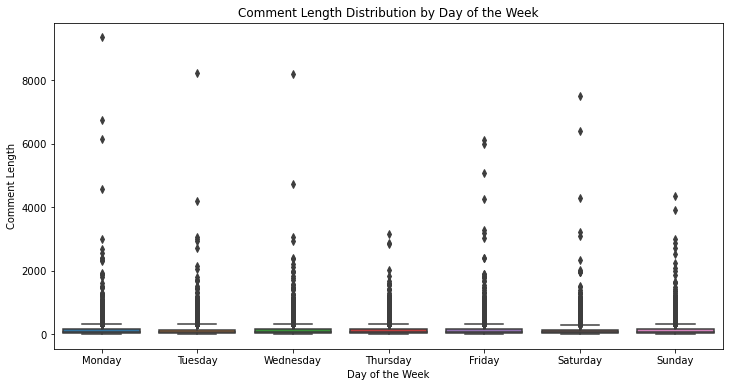

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='comment_length', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Comment Length Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Comment Length')
plt.show()


Conclusion: Box plot showing the distribution of comment lengths by day of the week.

# 21. Hourly Comment Volume

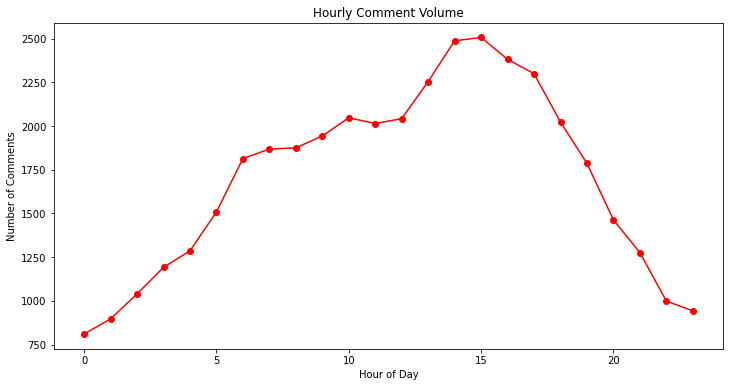

In [22]:
plt.figure(figsize=(12, 6))
df.groupby('hour').size().plot(kind='line', marker='o', color='red')
plt.title('Hourly Comment Volume')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Comments')
plt.show()


Conclusion: Line plot showing the volume of comments by hour of the day.

# 22. Most Frequent Words by Sentiment

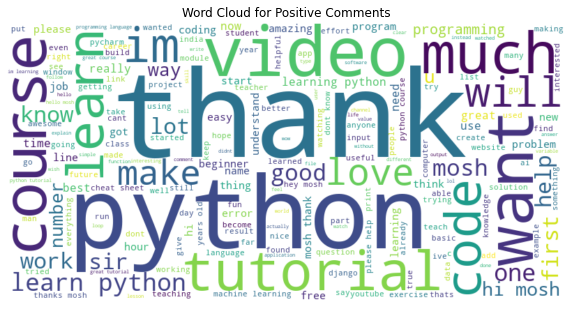

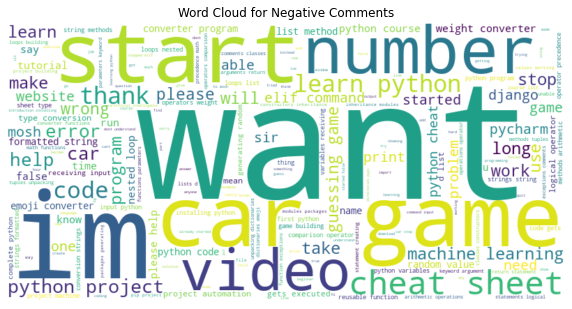

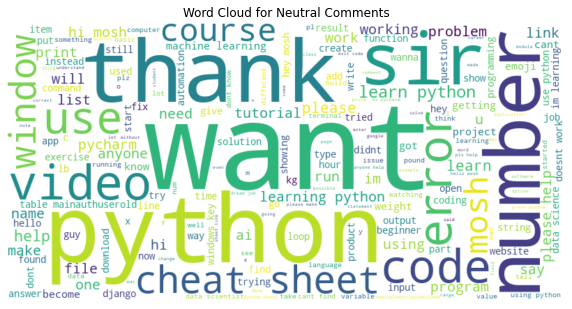

In [23]:
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    text = ' '.join(df[df['sentiment_label'] == sentiment]['cleaned_comment'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Comments')
    plt.show()


Conclusion: Generate word clouds for positive, negative, and neutral comments separately.



# 23. Commenter Activity Over Time

d:\Users\Admin\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1167: UserWarning: Attempting to set identical left == right == 19045.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


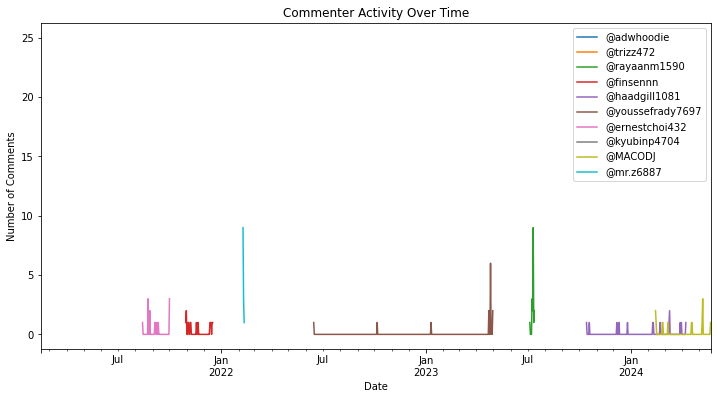

In [24]:
plt.figure(figsize=(12, 6))
for commenter in top_commenters.index:
    commenter_df = df[df['commenter'] == commenter]
    commenter_df.resample('D').size().plot(label=commenter)

plt.title('Commenter Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.legend(loc='upper right')
plt.show()


Conclusion: Line plots showing the activity of top commenters over time.

# 24. Time Series Analysis of Sentiment Distribution

<Figure size 864x432 with 0 Axes>

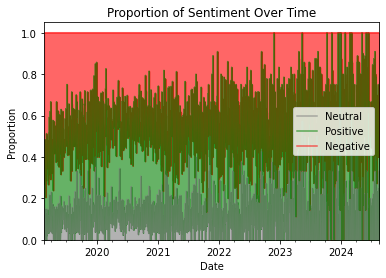

In [25]:
plt.figure(figsize=(12, 6))
df.resample('D').apply(lambda x: x['sentiment_label'].value_counts(normalize=True)).unstack().plot(kind='area', stacked=True, alpha=0.6, color=['gray', 'green', 'red'])
plt.title('Proportion of Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(['Neutral', 'Positive', 'Negative'])
plt.show()


Conclusion: Area plot showing the proportion of sentiment categories over time.

# 25. Cumulative Sentiment Over Time

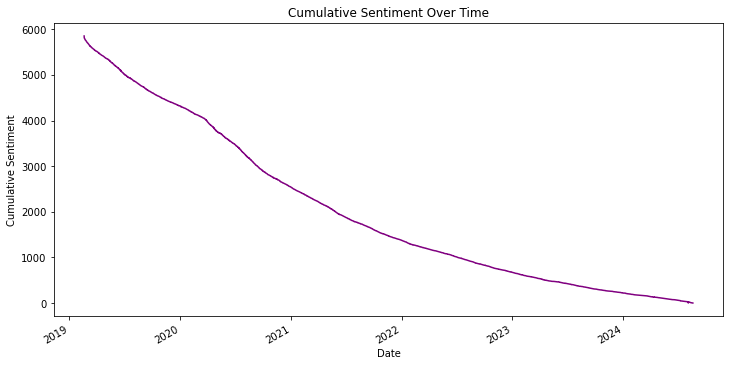

In [26]:
plt.figure(figsize=(12, 6))
df['cumulative_sentiment'] = df['sentiment'].cumsum()
df['cumulative_sentiment'].plot(kind='line', color='purple')
plt.title('Cumulative Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sentiment')
plt.show()


Conclusion: Line plot showing cumulative sentiment values over time.

# 26. Sentiment by Weekday

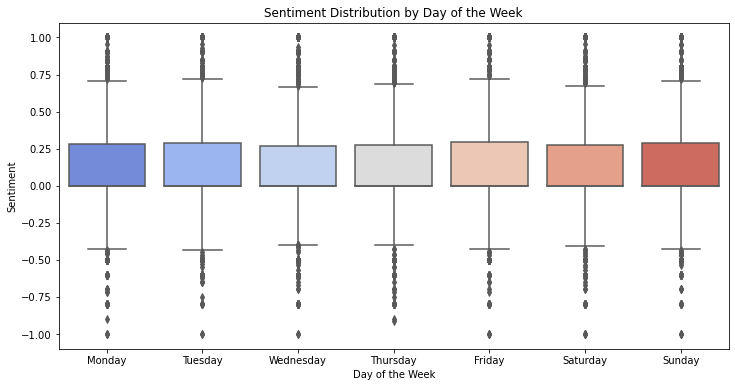

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='sentiment', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='coolwarm')
plt.title('Sentiment Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sentiment')
plt.show()


Conclusion: Box plot showing sentiment distribution by day of the week.

# 27. Most Frequent Positive and Negative Words

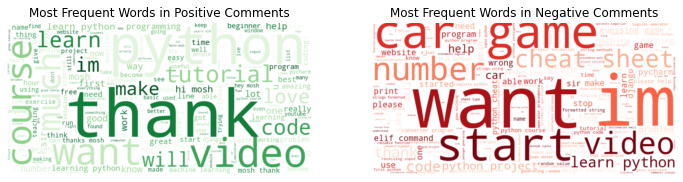

In [28]:
from collections import Counter

positive_words = ' '.join(df[df['sentiment_label'] == 'positive']['cleaned_comment'].tolist())
negative_words = ' '.join(df[df['sentiment_label'] == 'negative']['cleaned_comment'].tolist())

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Comments')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Comments')

plt.show()


Conclusion: Generate word clouds showing the most frequent words in positive and negative comments.



# 28. Sentiment Transition Matrix

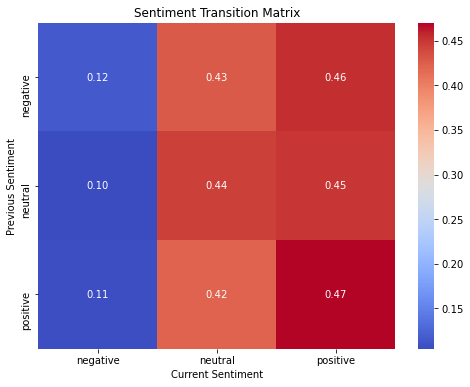

In [30]:
df['prev_sentiment'] = df['sentiment_label'].shift(1)
transition_matrix = pd.crosstab(df['prev_sentiment'], df['sentiment_label'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Sentiment Transition Matrix')
plt.xlabel('Current Sentiment')
plt.ylabel('Previous Sentiment')
plt.show()


Conclusion: Heatmap showing transitions between different sentiment states from one comment to the next.

